# 情感分析

项目参考https://github.com/bentrevett/pytorch-sentiment-analysis

在这个notebook项目中，用PyTorch和TorchText来做情感分析(检测一段文字的情感是正面的还是负面的)。我们会使用[IMDb 数据集](http://ai.stanford.edu/~amaas/data/sentiment/)，即电影评论。

模型从简单到复杂，依次构建三种模型：
- Word Averaging模型
- RNN/LSTM模型
- CNN模型

## 第一步：导入豆瓣电影数据集，只有训练集和测试集

- TorchText中的一个重要概念是`Field`。`Field`决定了你的数据会被怎样处理。在我们的情感分类任务中，我们所需要接触到的数据有文本字符串和两种情感，"pos"或者"neg"。
- `Field`的参数制定了数据会被怎样处理。
- 我们使用`TEXT` field来定义如何处理电影评论，使用`LABEL` field来处理两个情感类别。
- 我们的`TEXT` field带有`tokenize='spacy'`，这表示我们会用[spaCy](https://spacy.io) tokenizer来tokenize英文句子。如果我们不特别声明`tokenize`这个参数，那么默认的分词方法是使用空格。

- `LABEL`由`LabelField`定义。这是一种特别的用来处理label的`Field`。我们后面会解释dtype。
- 更多关于`Fields`，参见https://github.com/pytorch/text/blob/master/torchtext/data/field.py
- 和之前一样，我们会设定random seeds使实验可以复现。


- TorchText支持很多常见的自然语言处理数据集。
- 下面的代码会自动下载IMDb数据集，然后分成train/test两个`torchtext.datasets`类别。数据被前面的`Fields`处理。IMDb数据集一共有50000电影评论，每个评论都被标注为正面的或负面的。

<font color=red><b>先了解下Spacy库：[spaCy介绍和使用教程](https://juejin.im/post/5971a4b9f265da6c42353332?utm_source=gold_browser_extension%5D)</b></font>  
<font color=red><b>再了解下torchtext库：[torchtext介绍和使用教程](https://blog.csdn.net/u012436149/article/details/79310176)：这个新手必看，不看下面代码听不懂</b></font> 

In [1]:
import torch
from torchtext import data


SEED = 1234
torch.manual_seed(SEED) #为CPU设置随机种子
torch.cuda.manual_seed(SEED)#为GPU设置随机种子
torch.backends.cudnn.deterministic = True  #可以提升一点训练速度，没有额外开销。

#创建两个Field 对象
TEXT = data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm')
#torchtext.data.Field : 用来定义字段的处理方法（文本字段，标签字段）
LABEL = data.LabelField(dtype=torch.float)
#LabelField是Field类的一个特殊子集，专门用于处理标签。 

In [2]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

KeyboardInterrupt: 

In [ ]:
print(vars(train_data.examples[0])) #查看数据集

## 第二步：训练集划分为训练集和验证集

- 由于我们现在只有train/test这两个分类，所以我们需要创建一个新的validation set。我们可以使用`.split()`创建新的分类。
- 默认的数据分割是 70、30，如果我们声明`split_ratio`，可以改变split之间的比例，`split_ratio=0.8`表示80%的数据是训练集，20%是验证集。
- 我们还声明`random_state`这个参数，确保我们每次分割的数据集都是一样的。

In [ ]:
import random
train_data, valid_data = train_data.split(random_state=random.seed(SEED)) #默认split_ratio=0.7

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

## 第三步：用训练集建立vocabulary

- 下一步我们需要创建 _vocabulary_ 。_vocabulary_ 就是把每个单词一一映射到一个数字。
![](assets/sentiment5.png)
- 我们使用最常见的25k个单词来构建我们的单词表，用`max_size`这个参数可以做到这一点。
- 所有其他的单词都用`<unk>`来表示。

In [ ]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.100d", unk_init=torch.Tensor.normal_)
#从预训练的词向量（vectors） 中，将当前(corpus语料库)词汇表的词向量抽取出来，构成当前 corpus 的 Vocab（词汇表）。
#预训练的 vectors 来自glove模型，每个单词有100维。glove模型训练的词向量参数来自很大的语料库，
#而我们的电影评论的语料库小一点，所以词向量需要更新，glove的词向量适合用做初始化参数。
LABEL.build_vocab(train_data) 

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

In [ ]:
print(list(LABEL.vocab.stoi.items())) # 只有两个类别值
print(list(TEXT.vocab.stoi.items())[:20])
#语料库单词频率越高，索引越靠前。前两个默认为unk和pad。
print("------"*10)
print(TEXT.vocab.freqs.most_common(20))
# 这里可以看到unk和pad没有计数

In [ ]:
print(TEXT.vocab.itos[:10]) #查看TEXT单词表

## 第四步：创建iterators，每个itartion都会返回一个batch的样本

- 最后一步数据的准备是创建iterators。每个itartion都会返回一个batch的examples。
- 我们会使用`BucketIterator`。`BucketIterator`会把长度差不多的句子放到同一个batch中，确保每个batch中不出现太多的padding。
- 严格来说，我们这份notebook中的模型代码都有一个问题，也就是我们把`<pad>`也当做了模型的输入进行训练。更好的做法是在模型中把由`<pad>`产生的输出给消除掉。在这节课中我们简单处理，直接把`<pad>`也用作模型输入了。由于`<pad>`数量不多，模型的效果也不差。
- 如果我们有GPU，还可以指定每个iteration返回的tensor都在GPU上。

In [ ]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#相当于把样本划分batch，把相等长度的单词尽可能的划分到一个batch，不够长的就用padding。
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
                                                        (train_data, valid_data, test_data), 
                                                        batch_size=BATCH_SIZE,
                                                        device=device)
'''
Iterator：标准迭代器

BucketIerator：相比于标准迭代器，会将类似长度的样本当做一批来处理，
因为在文本处理中经常会需要将每一批样本长度补齐为当前批中最长序列的长度，
因此当样本长度差别较大时，使用BucketIerator可以带来填充效率的提高。
除此之外，我们还可以在Field中通过fix_length参数来对样本进行截断补齐操作。

BPTTIterator: 基于BPTT(基于时间的反向传播算法)的迭代器，一般用于语言模型中。
'''

In [ ]:
print(next(iter(train_iterator)).label.shape)
print(next(iter(train_iterator)).text.shape)  
# 多运行一次可以发现一条评论的单词长度会变
# 下面text的维度983*64，983为一条评论的单词长度

In [ ]:
# 取出一句评论
batch = next(iter(train_iterator))
print(batch.text.shape) 
print([TEXT.vocab.itos[i] for i in batch.text[:,0]])
# 可以看到这句话的长度是1077，最后面有很多pad

## 第五步：创建Word Averaging模型

### Word Averaging模型

- 我们首先介绍一个简单的Word Averaging模型。这个模型非常简单，我们把每个单词都通过`Embedding`层投射成word embedding vector，然后把一句话中的所有word vector做个平均，就是整个句子的vector表示了。接下来把这个sentence vector传入一个`Linear`层，做分类即可。

![](assets/sentiment8.png)

- 我们使用[`avg_pool2d`](https://pytorch.org/docs/stable/nn.html?highlight=avg_pool2d#torch.nn.functional.avg_pool2d)来做average pooling。我们的目标是把sentence length那个维度平均成1，然后保留embedding这个维度。

![](assets/sentiment9.png)

- `avg_pool2d`的kernel size是 (`embedded.shape[1]`, 1)，所以句子长度的那个维度会被压扁。

![](assets/sentiment10.png)

![](assets/sentiment11.png)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class WordAVGModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        #vocab_size=25002，embedding_dim=100，padding_idx：遇到pad的单词用0填充     
        self.fc = nn.Linear(embedding_dim, output_dim) #output_dim=1
        
    def forward(self, text): # text: [seq_len,batch_size]
        embedded = self.embedding(text)  # embedded = [seq_len, batch_size, embedding_dim] 
        embedded = embedded.permute(1, 0, 2) # [batch_size, seq_len, embedding_dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)   
        # kernel size=(embedded.shape[1], 1), 会将句子的长度压缩到1，[batch_size, 1, embedding_dim]最终将每句话用一个向量表示
        # [batch_size, embedding_dim] 把句子长度的维度压扁为1，并降维
        
        return self.fc(pooled)  #（batch_size, embedding_dim）*（embedding_dim, output_dim）=（batch_size,output_dim）

In [ ]:
VOCAB_SZIE = len(TEXT.vocab) #25002
EMBEDDING_DIM = 100
OUTPUT_DIM = 1 
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 
# TEXT.pad_token = pad
# PAD_IDX = 1 为pad的索引

model = WordAVGModel(VOCAB_SZIE, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [ ]:
def count_parameters(model): #统计模型参数
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

## 第六步：初始化参数

In [ ]:
# 把模型参数初始化成glove的向量参数
pretrained_embeddings = TEXT.vocab.vectors  # 取出glove embedding词向量的参数
model.embedding.weight.data.copy_(pretrained_embeddings) #遇到_的语句直接替换，不需要另外赋值=
#把上面vectors="glove.6B.100d"取出的词向量作为初始化参数，数量为25000*100个参数

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token] # UNK_IDX=0

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) 
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
#词汇表25002个单词，前两个unk和pad也需要初始化成EMBEDDING_DIM维的向量

## 第七步：训练模型

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters()) 
loss_fn = nn.BCEWithLogitsLoss()  #BCEWithLogitsLoss：二分类损失函数
# nn.BCEWithLogitsLoss()看这个：https://blog.csdn.net/qq_22210253/article/details/85222093
model = model.to(device) 
loss_fn = loss_fn.to(device) 

In [ ]:
def binary_accuracy(preds, y): 
    '''计算准确度，即预测和实际标签的相匹配的个数'''
    rounded_preds = torch.round(torch.sigmoid(preds)) #.round函数：四舍五入[neg: 0, pos: 1]
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc


def train(model, iterator, optimizer, loss_fn):
    epoch_loss = 0
    epoch_acc = 0
    total_len = 0
    model.train()  #训练时会用到dropout、归一化等方法，但测试的时候不能用dropout等方法
    
    for batch in iterator: 
        optimizer.zero_grad() 
        
        preds = model(batch.text).squeeze(1) # squeeze(1)压缩维度，和batch.label维度对上 
        loss = loss_fn(preds, batch.label)
        acc = binary_accuracy(preds, batch.label)
             
        loss.backward() 
        optimizer.step() 
        
        epoch_loss += loss.item() * len(batch.label)
        #得到一个batch累加得到所有样本损失
        
        epoch_acc += acc.item() * len(batch.label)
        #（acc.item()：一个batch的正确率） *batch数 = 正确数, 累加得到所有训练样本正确数。
        
        total_len += len(batch.label)
        #计算train_iterator所有样本的数量，不出意外应该是17500
        
    return epoch_loss / total_len, epoch_acc / total_len #得到所有的batch的平均loss和平均acc

In [ ]:
def evaluate(model, iterator, loss_fn):
    epoch_loss = 0
    epoch_acc = 0
    total_len = 0
    model.eval()
    #转换成测试模式，冻结dropout层或其他层。
    
    with torch.no_grad():  
        for batch in iterator: 
            
            preds = model(batch.text).squeeze(1)
            loss = loss_fn(preds, batch.label)
            acc = binary_accuracy(preds, batch.label)
            
            epoch_loss += loss.item() * len(batch.label)
            epoch_acc += acc.item() * len(batch.label)
            total_len += len(batch.label)
    model.train()
    return epoch_loss / total_len, epoch_acc / total_len

In [ ]:
import time 

def epoch_time(start_time, end_time): 
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## 第八步：查看模型运行结果

In [ ]:
# kaggleGPU跑的花了2分钟
N_EPOCHS = 20
best_valid_loss = float('inf') 

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, loss_fn) # 得到训练集每个epoch的平均损失和准确率
    valid_loss, valid_acc = evaluate(model, valid_iterator, loss_fn) # 验证集每个epoch的平均损失和准确率，model传入的是训练完的参数
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss: 
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'wordavg-model.pth')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## 第九步：预测结果

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np

def create_download_link(title = "Download model file", filename = "CNN-model.pt"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='wordavg-model.pth')

In [1]:
model.load_state_dict(torch.load("wordavg-model.pth"))

NameError: name 'model' is not defined

In [5]:
import spacy  
nlp = spacy.load('en_core_web_sm') 

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # print(tokenized) = ['I', 'love', 'This', 'film', 'bad']
    indexed = [TEXT.vocab.stoi[t] for t in tokenized] 
    
    tensor = torch.LongTensor(indexed).to(device) #seq_len
    # 所有词向量都应该变成LongTensor
    
    tensor = tensor.unsqueeze(1) 
    #模型的输入是[seq_len, batch_size],这里batch_size为1
    
    pred = torch.sigmoid(model(tensor))
    # 预测准确率，在0，1之间，需要sigmoid下
    
    return pred.item()

In [29]:
predict_sentiment("I love This film bad")

0.9373546242713928

In [30]:
predict_sentiment("This film is great")

1.0

## RNN模型

- 下面我们尝试把模型换成一个**recurrent neural network** (RNN)。RNN经常会被用来encode一个sequence
$$h_t = \text{RNN}(x_t, h_{t-1})$$
- 我们使用最后一个hidden state $h_T$来表示整个句子。
- 然后我们把$h_T$通过一个线性变换$f$，然后用来预测句子的情感。

![](assets/sentiment1.png)

![](assets/sentiment7.png)

双向RNN网络
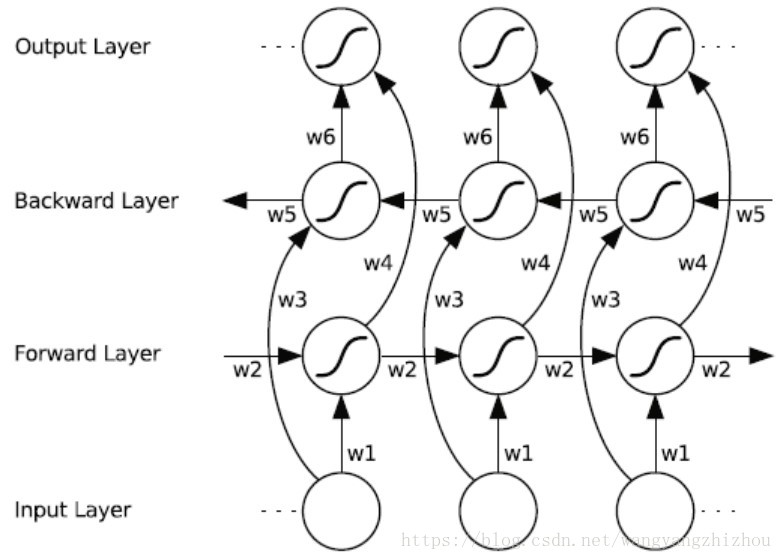

In [32]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        #bidirectional：是否双向循环RNN
        self.fc = nn.Linear(hidden_size*2, output_size)
        # 这里hidden_dim乘以2是因为是双向，需要拼接两个方向，跟n_layers的层数无关
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text): # text=[seq_len, batch_size]
        embedded = self.dropout(self.embedding(text)) #[seq_len, batch_size, embedding_dim]
        output, (hidden, cell) = self.lstm(embedded)
        # output = [seq_len, batch_size, hidden_dim * num directions]
        # hidden = cell = [num layers * num directions, batch_size, hidden_dim]
        
        # 这里的num layers * num directions可以看上面图，上面图除掉输入输出层只有两层双向网络。
        # num layers = 2表示需要纵向上在加两层双向，总共有4层神经元,只需要最后一层的双向lstm即可
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)) 
        # hidden = [batch_size, hidden_dim * num directions]
        # 看下上面图示，最后前向和后向输出的隐藏层会concat到输出层，4层神经元最后两层作为最终的输出。
        # 这里因为我们只需要得到最后一个时间序列的输出，所以最终输出的hidden跟seq_len无关。
        
        return self.fc(hidden.squeeze(0)) # #sequeeze()只有维度为1才会去掉，输出[batch size, output_dim]

In [36]:
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [34]:
print(f'The model has {count_parameters(model):,} trainable parameters')
# 比averge model模型多了一倍的参数

The model has 4,810,857 trainable parameters


In [37]:
# 同上初始化
model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1419,  0.0282,  0.2185,  ..., -0.1100, -0.1250,  0.0282],
        [-0.3326, -0.9215,  0.9239,  ...,  0.5057, -1.2898,  0.1782],
        [-0.8304,  0.3732,  0.0726,  ..., -0.0122,  0.2313, -0.2783]])


## 训练RNN模型

In [38]:
optimizer = optim.Adam(model.parameters())
model = model.to(device)

In [39]:
# 用kaggleGPU跑花了40分钟。
N_EPOCHS = 20
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 1s
	Train Loss: 0.667 | Train Acc: 59.09%
	 Val. Loss: 0.633 |  Val. Acc: 64.67%
Epoch: 02 | Epoch Time: 2m 1s
	Train Loss: 0.663 | Train Acc: 60.33%
	 Val. Loss: 0.669 |  Val. Acc: 69.21%
Epoch: 03 | Epoch Time: 2m 2s
	Train Loss: 0.650 | Train Acc: 61.06%
	 Val. Loss: 0.579 |  Val. Acc: 70.55%
Epoch: 04 | Epoch Time: 2m 2s
	Train Loss: 0.493 | Train Acc: 77.43%
	 Val. Loss: 0.382 |  Val. Acc: 83.43%
Epoch: 05 | Epoch Time: 2m 2s
	Train Loss: 0.394 | Train Acc: 83.71%
	 Val. Loss: 0.338 |  Val. Acc: 85.97%
Epoch: 06 | Epoch Time: 2m 3s
	Train Loss: 0.338 | Train Acc: 86.26%
	 Val. Loss: 0.309 |  Val. Acc: 87.21%
Epoch: 07 | Epoch Time: 2m 2s
	Train Loss: 0.292 | Train Acc: 88.37%
	 Val. Loss: 0.295 |  Val. Acc: 88.73%
Epoch: 08 | Epoch Time: 2m 3s
	Train Loss: 0.252 | Train Acc: 90.26%
	 Val. Loss: 0.300 |  Val. Acc: 89.31%
Epoch: 09 | Epoch Time: 2m 2s
	Train Loss: 0.246 | Train Acc: 90.51%
	 Val. Loss: 0.282 |  Val. Acc: 88.76%
Epoch: 10 | Epoch Time: 2m 3

In [40]:
# 下载文件到本地
from IPython.display import HTML
import pandas as pd
import numpy as np

def create_download_link(title = "Download model file", filename = "wordavg-model.pt"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='lstm-model.pt')

In [41]:
model.load_state_dict(torch.load('lstm-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.304 | Test Acc: 88.11%


In [44]:
predict_sentiment("I feel This film bad")

0.3637591600418091

In [43]:
predict_sentiment("This film is great")

0.9947803020477295

## CNN模型

In [45]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, out_channels = n_filters, 
                                    kernel_size = (fs, embedding_dim)) for fs in filter_sizes])
        # in_channels：输入的channel，文字都是1
        # out_channels：输出的channel维度
        # fs：每次滑动窗口计算用到几个单词
        # for fs in filter_sizes打算用好几个卷积模型最后concate起来看效果。
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        text = text.permute(1, 0) # [batch size, sent len]
        embedded = self.embedding(text) # [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1) # [batch size, 1, sent len, emb dim]
        # 升维是为了和nn.Conv2d的输入维度吻合，把channel列升维。
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved = [batch size, n_filters, sent len - filter_sizes+1]
        # 有几个filter_sizes就有几个conved
    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # 把conv的第三个维度最大池化了
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        # 把 len(filter_sizes)个卷积模型concate起来传到全连接层。
            
        return self.fc(cat)

In [47]:
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')
# 比averge model模型参数差不多

The model has 2,620,801 trainable parameters


In [48]:
# 同上，需要花8分钟左右
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'CNN-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.652 | Train Acc: 61.81%
	 Val. Loss: 0.527 |  Val. Acc: 76.20%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.427 | Train Acc: 80.66%
	 Val. Loss: 0.358 |  Val. Acc: 84.36%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.304 | Train Acc: 87.14%
	 Val. Loss: 0.318 |  Val. Acc: 86.45%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.215 | Train Acc: 91.42%
	 Val. Loss: 0.313 |  Val. Acc: 86.92%
Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.156 | Train Acc: 94.18%
	 Val. Loss: 0.326 |  Val. Acc: 87.01%
Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.105 | Train Acc: 96.33%
	 Val. Loss: 0.344 |  Val. Acc: 87.16%
Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.075 | Train Acc: 97.61%
	 Val. Loss: 0.372 |  Val. Acc: 87.28%
Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.052 | Train Acc: 98.39%
	 Val. Loss: 0.403 |  Val. Acc: 87.21%
Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.041 | Train Acc: 98.64%
	 Val. Loss: 0.433 |  Val. Acc: 87.09%
Epoch: 10 | Epoch T

In [49]:
# 发现上面结果过拟合了，同学们可以自行调参
model.load_state_dict(torch.load('CNN-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.339 | Test Acc: 85.68%


In [50]:
predict_sentiment("I feel This film bad")

0.6535547375679016

In [52]:
predict_sentiment("This film is great well") 
# 我后面加了个well，不加会报错，因为我们的FILTER_SIZES = [3,4,5]有设置为5，所以输出的句子长度不能小于5

0.9950380921363831

In [54]:
# kaggle上下载模型文件到本地
from IPython.display import HTML
import pandas as pd
import numpy as np

def create_download_link(title = "Download model file", filename = "CNN-model.pt"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='CNN-model.pt')